<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/qmkdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 247 (delta 10), reused 26 (delta 5), pack-reused 215
Receiving objects: 100% (247/247), 17.07 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [2]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

### Two moons example

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models


/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [4]:
X, y = make_moons(n_samples=2000, noise=0.2, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

42/42 [==============================] - 2s 910us/step
[[0.12925543 0.8707446 ]
 [0.7048589  0.29514107]
 [0.10257526 0.8974247 ]
 [0.13454378 0.8654562 ]
 [0.42454174 0.5754583 ]
 [0.9231668  0.07683314]
 [0.4038729  0.59612715]
 [0.13573886 0.8642611 ]
 [0.8521012  0.14789876]
 [0.1633253  0.8366747 ]]
0.9348484848484848
0.018782983 0.018782983


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


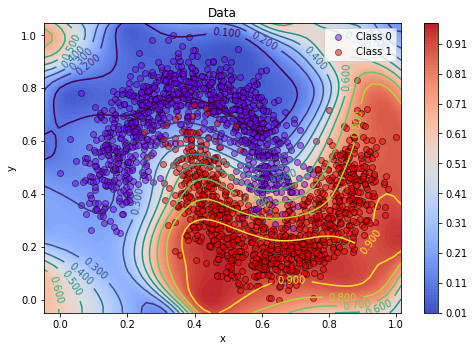

In [6]:
fm_x = layers.QFeatureMapRFF(2, dim=150, gamma=20, random_state=17)
qmkdc = models.DMKDClassifier(fm_x=fm_x, dim_x=150, num_classes=2)
qmkdc.compile()
qmkdc.fit(X_train, y_train, epochs=1)
out = qmkdc.predict(X_test)
print(out[:10])
print(accuracy_score(y_test, out[:,1] >= 0.5))
pl.figure(figsize = (8,16/3))    
plot_decision_region(X_test, gen_pred_fun(qmkdc))
plot_data(X, y)

0.9363636363636364
0.0084854495 0.0084854495


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


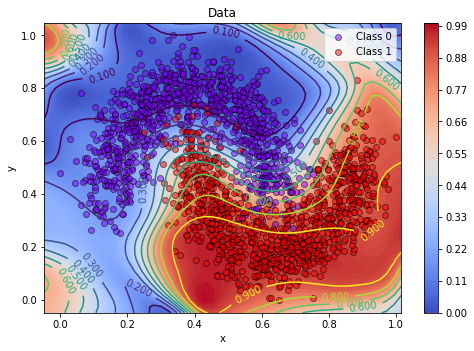

In [7]:
qmkdc1 = models.DMKDClassifierSGD(input_dim=2, dim_x=150, num_classes=2, num_eig=5, gamma=20, random_state=17)
qmkdc1.set_rhos(qmkdc.get_rhos())
out = qmkdc1.predict(X_test)
print(accuracy_score(y_test, out[:,1] >= 0.5))
pl.figure(figsize = (8,16/3))    
plot_decision_region(X_test, gen_pred_fun(qmkdc1))
plot_data(X, y)


42/42 [==============================] - 1s 3ms/step - loss: 0.1512
0.9363636363636364
0.00041006712 0.00041006712


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


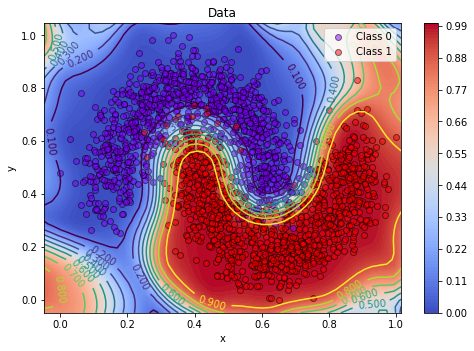

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmkdc1.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy())
qmkdc1.set_rhos(qmkdc.get_rhos())
y_train_bin = tf.reshape (tf.keras.backend.one_hot(y_train, 2), (-1,2))
qmkdc1.fit(X_train, y_train_bin, epochs=1)
print(accuracy_score(y_test, out[:,1] >= 0.5))
pl.figure(figsize = (8,16/3))    
plot_decision_region(X_test, gen_pred_fun(qmkdc1))
plot_data(X, y)


42/42 [==============================] - 1s 3ms/step - loss: 0.4016
0.9363636363636364


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.0012390867 0.0012390867


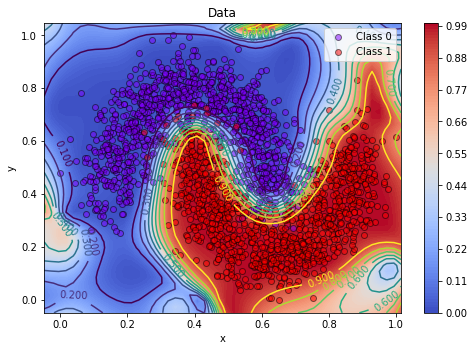

In [9]:
qmkdc1 = models.DMKDClassifierSGD(input_dim=2, dim_x=150, num_classes=2, num_eig=5, gamma=20, random_state=17)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmkdc1.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy())
y_train_bin = tf.reshape (tf.keras.backend.one_hot(y_train, 2), (-1,2))
qmkdc1.fit(X_train, y_train_bin, epochs=1)
print(accuracy_score(y_test, out[:,1] >= 0.5))
pl.figure(figsize = (8,16/3))    
plot_decision_region(X_test, gen_pred_fun(qmkdc1))
plot_data(X, y)

In [10]:
qmkdc.summary()

Model: "dmkd_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_feature_map_rff_1 (QFeatur multiple                  450       
_________________________________________________________________
q_measure_density (QMeasureD multiple                  22500     
_________________________________________________________________
q_measure_density_1 (QMeasur multiple                  22500     
_________________________________________________________________
cross_product (CrossProduct) multiple                  0         
Total params: 45,452
Trainable params: 45,450
Non-trainable params: 2
_________________________________________________________________


In [11]:
qmkdc1.summary()

Model: "dmkd_classifier_sgd_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_feature_map_rff_3 (QFeatur multiple                  450       
_________________________________________________________________
q_measure_density_eig_2 (QMe multiple                  755       
_________________________________________________________________
q_measure_density_eig_3 (QMe multiple                  755       
Total params: 1,960
Trainable params: 1,960
Non-trainable params: 0
_________________________________________________________________


In [12]:
from sklearn.datasets import load_digits

X,y = load_digits(return_X_y=True)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, stratify=y, random_state=42)

print(X_train.shape)
print(np.max(X, axis=0))
print(np.min(y))


(1203, 64)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0


In [13]:
fm_x = layers.QFeatureMapRFF(64, dim=150, gamma=0.375, random_state=17)
qmkdc_dig = models.DMKDClassifier(fm_x=fm_x, dim_x=150, num_classes=10)
qmkdc_dig.compile()
qmkdc_dig.fit(X_train, y_train, epochs=1)
out = qmkdc_dig.predict(X_test)
print(accuracy_score(y_test, np.argmax(out, axis=1)))


38/38 [==============================] - 0s 992us/step
0.9377104377104377


In [15]:
qmkdc1_dig = models.DMKDClassifierSGD(input_dim=64, dim_x=150, num_classes=10, gamma=0.375, random_state=17)
qmkdc1_dig.set_rhos(qmkdc_dig.get_rhos())
out = qmkdc1_dig.predict(X_test)
#print(out[:10])
print(accuracy_score(y_test, np.argmax(out, axis=1)))


0.9377104377104377


In [16]:
qmkdc1_dig = models.DMKDClassifierSGD(input_dim=64, dim_x=150, num_classes=10, num_eig=5, gamma=0.375, random_state=17)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmkdc1_dig.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy())
y_train_bin = tf.reshape (tf.keras.backend.one_hot(y_train, 10), (-1,10))
qmkdc1_dig.set_rhos(qmkdc_dig.get_rhos())
qmkdc1_dig.fit(X_train, y_train_bin, epochs=2)
out = qmkdc1_dig.predict(X_test)
print(accuracy_score(y_test, np.argmax(out, axis=1)))


Epoch 1/2
38/38 [==============================] - 2s 5ms/step - loss: 0.5630
Epoch 2/2
38/38 [==============================] - 0s 5ms/step - loss: 0.3047
0.9545454545454546


In [17]:
qmkdc_dig.summary()
qmkdc1_dig.summary()

Model: "dmkd_classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_feature_map_rff_4 (QFeatur multiple                  9750      
_________________________________________________________________
q_measure_density_2 (QMeasur multiple                  22500     
_________________________________________________________________
q_measure_density_3 (QMeasur multiple                  22500     
_________________________________________________________________
q_measure_density_4 (QMeasur multiple                  22500     
_________________________________________________________________
q_measure_density_5 (QMeasur multiple                  22500     
_________________________________________________________________
q_measure_density_6 (QMeasur multiple                  22500     
_________________________________________________________________
q_measure_density_7 (QMeasur multiple            